In [15]:
import torch
import numba
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
from pathlib import Path
import gc

import os
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from albumentations import (
    Compose, ToFloat, FromFloat, RandomRotate90, Flip, OneOf, MotionBlur, MedianBlur, Blur,
    ShiftScaleRotate, OpticalDistortion, GridDistortion, RandomBrightnessContrast,
    HueSaturationValue, 
)
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90, ElasticTransform,RandomBrightness, RandomContrast,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue, RandomGamma,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, Blur, RandomCrop, IAAAffine
)
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import albumentations as albu
from typing import Callable, List, Tuple 
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [16]:
HEIGHT = 137
WIDTH = 236

@numba.jit()
def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{ROOT}{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{ROOT}{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    HEIGHT = 137
    WIDTH = 236
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH) for df in image_df_list]
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images

def prepare_image_128(data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(f'{ROOT}/{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_parquet(f'{ROOT}/{data_type}_image_data_{i}.parquet')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    HEIGHT = 137
    WIDTH = 236 
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH) for df in image_df_list]
    del image_df_list
    gc.collect()

    images = np.concatenate(images, axis=0)
    images = np.array([crop_resize(i) for i in images])

    return images


@numba.jit()
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

@numba.jit()
def crop_resize(img0, size=128, pad=16):
    img0 = 255 - img0
    img0[img0 < 80] = 0
    img0[img0 > 100] = 255
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))

In [17]:
ROOT = Path("./data/")
ROOT

PosixPath('data')

In [28]:
indices=[0] #, 1, 2, 3]
train = pd.read_csv(f'{ROOT}/train.csv')
train_labels_ = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values

train_images_ = prepare_image_128(indices=indices)

mskf = MultilabelStratifiedKFold(n_splits=5, random_state=2020, shuffle=True)
mskf
train_index, test_index  = next(mskf.split(train_images_, train_labels_[:50210]))

train_images = train_images_[train_index]
test_images = train_images_[test_index]

train_labels = train_labels_[train_index]
test_labels = train_labels_[test_index]

image_df_list 1


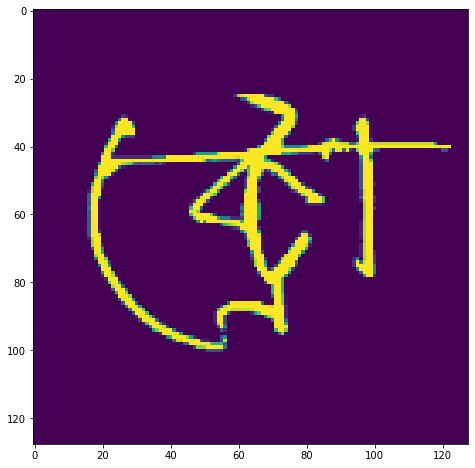

In [29]:
image = train_images[0]#.reshape(128,128)
plt.figure(figsize=(8, 8))
plt.imshow(image.astype(int))
plt.show()

In [30]:
def augment_and_show(aug, image):
    image = aug(image=image)['image']
    plt.figure(figsize=(20, 10))
    plt.imshow(image)

In [31]:
aug = albu.Compose([
        #albu.Resize(320, 640),
        #albu.Resize(320, 480),
        albu.Flip(p=0.5),
        albu.ShiftScaleRotate(p=.5, scale_limit=(-.1, .1), rotate_limit=30, shift_limit=(-.1,.1), border_mode=0),
        albu.GridDistortion(p=.5, border_mode=0, distort_limit=.15),
        albu.OpticalDistortion(p=1, distort_limit=.5, shift_limit=.1, border_mode=0),
        #albu.ElasticTransform(p=.5, alpha=100, sigma=10, alpha_affine=5),

        albu.OneOf([
            albu.RandomBrightness(p=.5, limit=.2),
#             albu.RandomSunFlare(p=.1,
#                           angle_lower=.1,
#                           angle_upper=.5,
#                           num_flare_circles_lower=1,
#                           num_flare_circles_upper =3,
#                           src_color=(180, 220, 30)),
            #albu.RandomGamma(p=.5,gamma_limit=(50, 200)),
            albu.RandomContrast(p=.5, limit=.2),
#             albu.JpegCompression(p=.1, quality_lower=10)
            
        ], p=.3),   
        albu.Blur(p=.3)
        #albu.RandomGamma(p=.3)
    ])

In [49]:
def show_examples(images: List[Tuple[str, np.ndarray]], aug):
    examples = len(images)
    width = int(examples ** .5)
    height = examples // width
    _indexes = [(i, j) for i in range(height) for j in range(width)]
    
    f, ax = plt.subplots(height, width, figsize=(16, 16))
    for n, (i, j), img in zip(range(examples), _indexes, images):
        if n % 2 == 0:
            img = aug(image=img)['image']
        
        ax[i, j].imshow(img)

    f.tight_layout()

def read_random_images(images, size: int=4) -> List[Tuple[str, np.ndarray]]:
    data = np.random.choice(len(images), size)
    result = []
    for d in data:
        _image = images[d]
        result.append(_image)
    
    return result

In [50]:
train_images[1].shape

(128, 128)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 10.7 µs


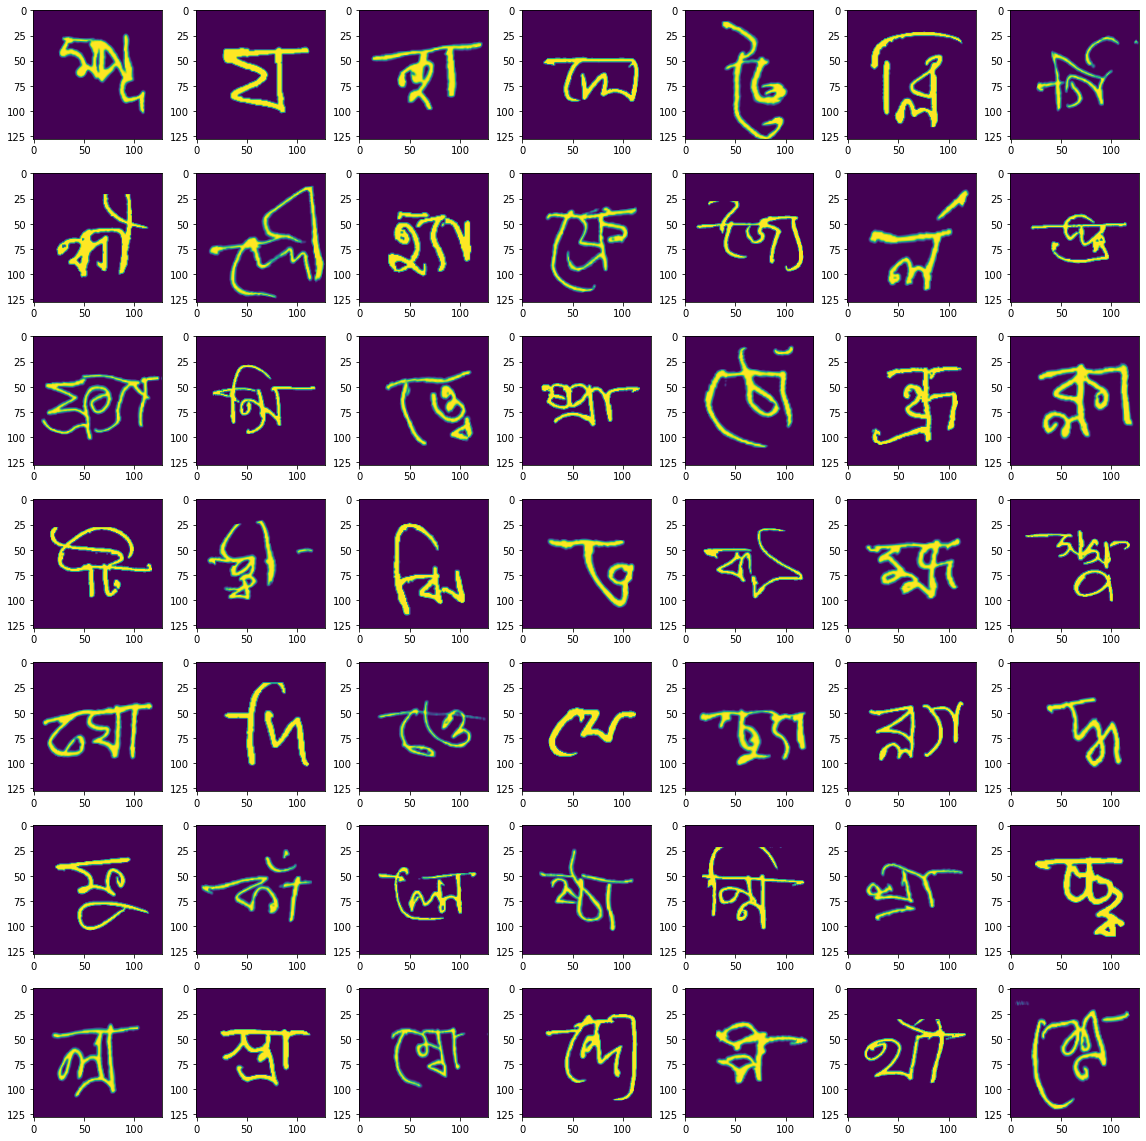

In [51]:
%time
aug = albu.Compose([
                    
        #albu.ShiftScaleRotate(p=.5, scale_limit=(-.05, .1), rotate_limit=10, shift_limit=(-.1,.1), border_mode=0),
        #albu.GridDistortion(p=.7, border_mode=0, distort_limit=.25),

        albu.ElasticTransform(p=1, alpha=70, sigma=9, alpha_affine=9),
        
        #albu.CenterCrop(112, 112, .1),
        # albu.CoarseDropout(max_holes=32, max_height=16, max_width=16, min_holes=4, min_height=2, min_width=2, fill_value=0, p=1),
        #albu.GridDropout(ratio=.25,p=1),
        #albu.JpegCompression(quality_lower=20, quality_upper=40, p=.1),
        #albu.Blur(blur_limit=3, p=.1),

])
images = read_random_images(train_images, 49)
show_examples(images, aug)

In [52]:
aug =  albu.GridDropout(ratio=.25, p=1)
augment_and_show(aug, torch.ones((128,128)))

AttributeError: 'Tensor' object has no attribute 'copy'

In [ ]:
for i in range(30):
    #aug = albu.RandomGamma(p=1)
    #aug = OpticalDistortion(p=1, distort_limit=.5, shift_limit=.1, border_mode=0)
    augment_and_show(aug, i_)

In [0]:
aug = Blur(blur_limit=3, p=1)
    #aug = OpticalDistortion(p=1, distort_limit=.5, shift_limit=.1, border_mode=0)
augment_and_show(aug, i_)

In [0]:
aug = Flip(p=1)
augment_and_show(aug, image)

In [0]:
aug = CLAHE(p=1)
augment_and_show(aug, image)

In [0]:
aug = GridDistortion(p=1)
augment_and_show(aug, image)

In [0]:
aug = ElasticTransform(alpha=.75, sigma=30, alpha_affine=10,p=1)
augment_and_show(aug, image)

In [0]:
aug = RandomBrightness(limit=.3, p=1)
augment_and_show(aug, image)

In [0]:
aug = RandomContrast(limit=.3, p=1)
augment_and_show(aug, image)

In [0]:
aug = ShiftScaleRotate(p=1, scale_limit=.2, rotate_limit=30, shift_limit=0.3, border_mode=2)
augment_and_show(aug, image)

In [0]:
plt.figure(figsize=(20, 10))
plt.imshow(image)
plt.show()
aug = Compose([Flip(), ShiftScaleRotate(shift_limit=.3, rotate_limit=3), RandomBrightness(limit=.4), GridDistortion(), ElasticTransform()]) #, CLAHE()])
for i in range(10):
    augment_and_show(aug, image)

In [0]:
augment_and_show(Blur(), image)

In [0]:
augment_and_show(RandomCrop(256,100), image)

In [0]:
from torchvision.transforms import RandomApply, RandomAffine

In [0]:
to_tuple(((-0.2, 0.2),(-0.2, 0.2)), 0)

In [0]:
aug = Shift(translate_percent={"x": (-0.95, 0.95)}, mode='constant', always_apply=True)

In [0]:
plt.imshow(image);
plt.show()
for i  in range(30):
    augment_and_show(aug, image)

In [0]:
import imgaug as ia
try:
    from imgaug import augmenters as iaa
except ImportError:
    import imgaug.imgaug.augmenters as iaa
    
class Shift(IAAAffine):
    """Place a regular grid of points on the input and randomly move the neighbourhood of these point around
    via affine transformations.

    Note: This class introduce interpolation artifacts to mask if it has values other than {0;1}

    Args:
        p (float): probability of applying the transform. Default: 0.5.

    Targets:
        image, mask
    """

    def __init__(self, scale=1.0, translate_percent=None, translate_px=None, rotate=0.0, shear=0.0, order=1, cval=0,
                 mode='reflect', always_apply=False, p=1):
        super(Shift, self).__init__(always_apply, p)
        self.scale = to_tuple(scale, 1.0)
        self.translate_percent = translate_percent
        self.translate_px = translate_px
        self.rotate = to_tuple(rotate)
        self.shear = to_tuple(shear)
        self.order = order
        self.cval = cval
        self.mode = mode

    @property
    def processor(self):
        return iaa.Affine(self.scale, self.translate_percent, self.translate_px, self.rotate, self.shear,
                          self.order, self.cval, self.mode)

    def get_transform_init_args_names(self):
        return ('scale', 'translate_percent', 'translate_px', 'rotate', 'shear', 'order', 'cval', 'mode')


In [0]:
image = cv2.imread("/content/drive/My Drive/severstal/train_images/90b461f2a.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [0]:
(256+1600)/(256*1600)

In [0]:
import os
for file in os.listdir("/content/drive/My Drive/severstal/test_images/")[:20]:
    image = cv2.imread("/content/drive/My Drive/severstal/test_images/" + file)
    print(image[0,0,:], image[255,1599,:], image[255,0,:], image[0,1599,:])

In [0]:
image.shape

In [0]:
import numba
numba.__version__

In [0]:
train

In [0]:
train['EncodedPixels'] = train['EncodedPixels'].fillna(0)
train.EncodedPixels[train.EncodedPixels != 0] = 1

In [0]:
train

In [0]:
plt.figure(figsize=(100, 10))
plt.plot(train[train['label'] == 'Gravel'].EncodedPixels)

In [0]:
train[train['label'] == 'Fish']

In [0]:
 r = torch.randint(0, 255, (3,4,5))

In [0]:
r

In [0]:
r1 = torch.cat((r[:,2:],r[:,:2]),1).permute(1,2,0)

In [0]:
plt.imshow(r.permute(1,2,0));
plt.show()
plt.imshow(r1)

In [0]:
r.permute(1,2,0).shape, r.shape